<a name='0'></a>

# RegNet: Designing Network Design Spaces

[RegNet](https://arxiv.org/abs/2003.13678) is a faster and efficient ConvNet architecture that introduced a new network design paradigm of designing network design spaces that contains many high performing architectures for different settings or hardwares or use cases.

What's in here:

* [1. Introduction](#1)
* [2. Design Network Space, AnyNet and RegNet](#2)
* [3. RegNet implementation](#3)
* [4. Final Notes](#4)
* [5. Reference Implementations](#5)

<a name='1'></a>
## 1. Introduction

Since the beginning of 2010s decade, deep convolutional neural networks have been the prime mover of most visual recognition tasks. ConvNets architectures such as AlexNet, VGG, and ResNet have demonstrated that massive datasets, depth, and residual connections can leads to networks that perform better.

Although there are existing networks that perform reasonably well, designing better, scalable,  and efficient architectures that can work on wide range of platforms is still one of the challenging tasks. Researchers have been trying to automate the network design process using Neural Architecture Search(NAS) and as results, NAS led to architectures like [MnasNet](https://arxiv.org/abs/1807.11626) and [EfficientNet](https://arxiv.org/abs/1905.11946v5). NAS seeks to automatically finds a good model within a search space but such particular model is usually limited to specific platform or other limited use cases rather than discovering the principles of designing networks.

To address and overcome the limitations of fully NAS based architectures, *the aim of the authors was to find simple models that are easy to understand, build on, and generalize*. Rather than designing individual network instances, they ***design design spaces*** that represents populations of networks with different structures(depth, width, groups, etc..). 

As conclusion, the central idea behind RegNet is designing novel design spaces that have simple and interpretable models.



<a name='2'></a>

## 2. Design Network Space, AnyNet and RegNet

The principal idea behind RegNet is discovering network design principles that can generalize across different settings rather than finding a single best network that only works in one specific settings.

The authors define design space as ***a large, possibly infinite, population of model architectures.***

AnyNet is the basic network in the design space. It contains a stem(3x3 conv with stride 2 and 32 filters), the network body (or convolution blocks) that performs the bulk of computations and final classification head(average pooling layer and fully connected layer with softmax activation) that predicts the output classes.

By just changing network width(number of channels), depth(number of convolutional blocks), channel width and bottleneck width, one can arrive at vast number of efficient networks that the authors termed as AnyNets and RegNets (there are so many version of those networks that only differ in sizes).

Below image depicts the structure of the basic network in design space. The stem is fixed across different version of AnyNets and RegNets. It's 3x3 convolution with strides of 2 and 32 filters/channels. The body of the network is made of convolution blocks that do major computations. The blocks are based on the standard residual bottleneck block with grouped convolutions. Each block contains 1x1 conv or pointwise convolution, 3x3 grouped conv, and a final 1x1 conv for restoring/reducing dimension. Each convolution layer is followed by batch normalization and ReLU. 





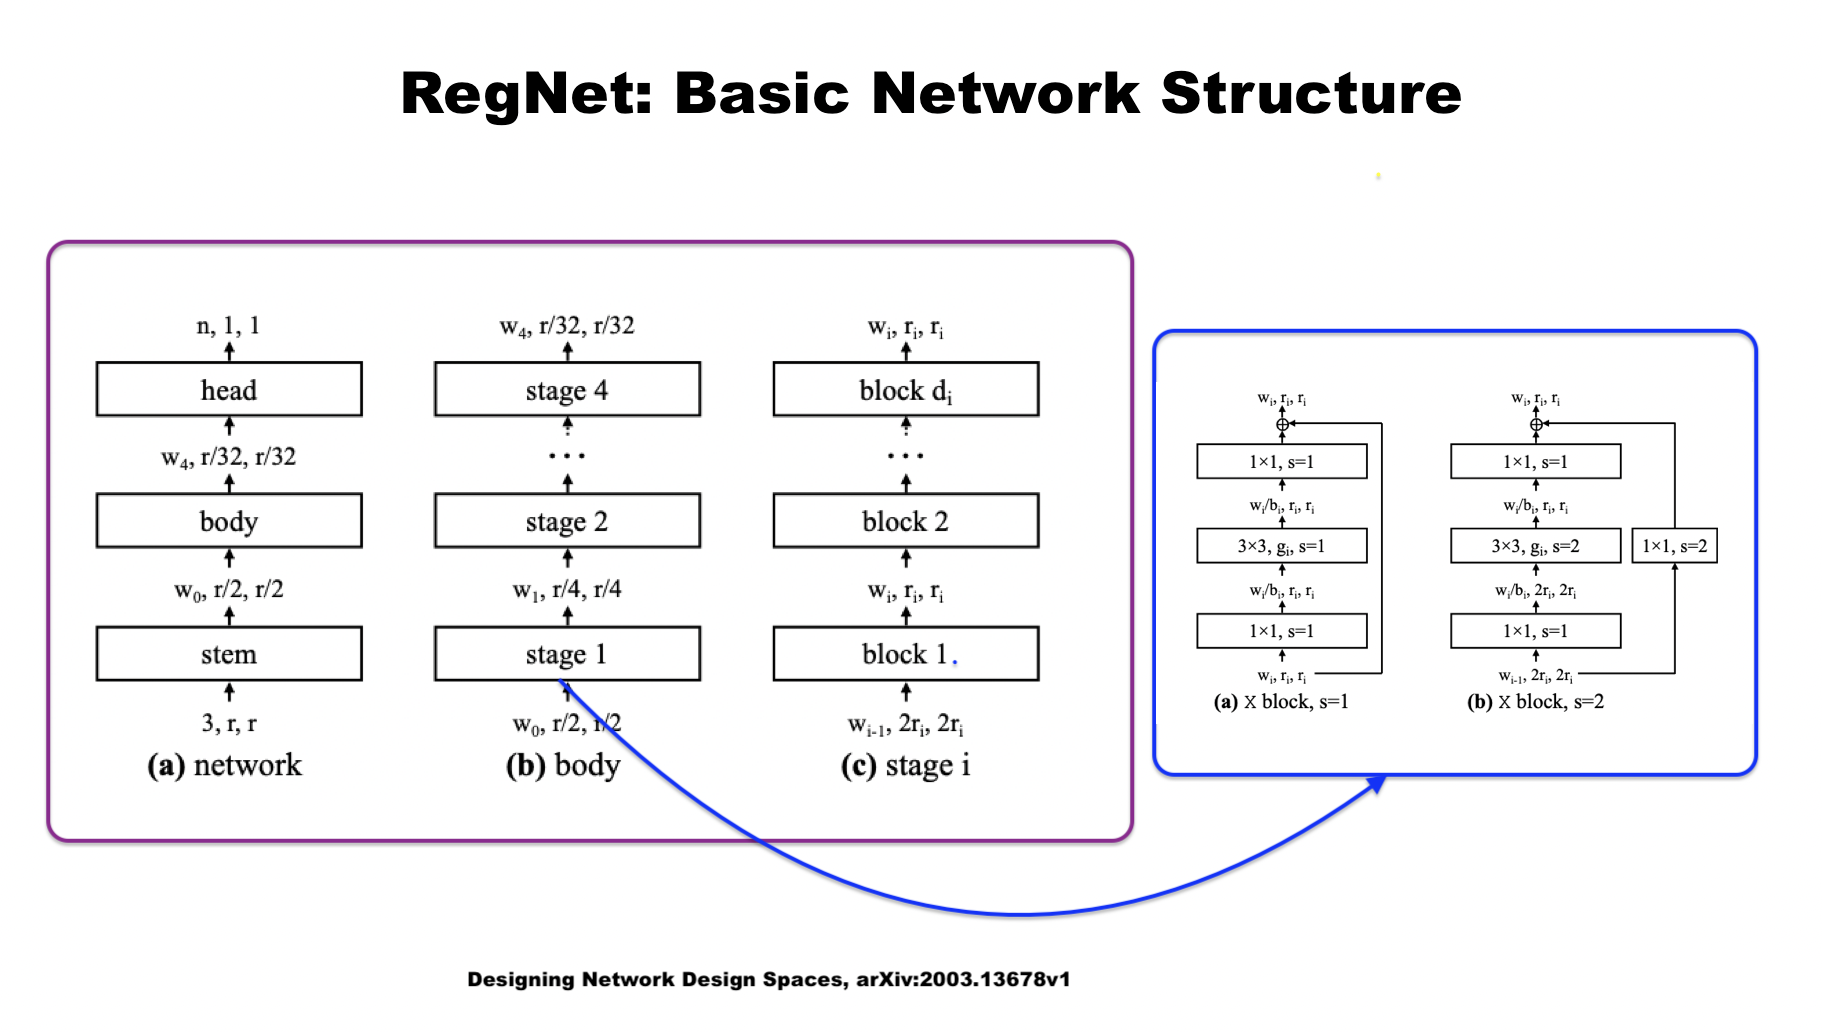

As we said, there are so many RegNet versions of the network that can be produced from the design space. The width and depth of RegNet models are deduced from a quantized linear function(the best models produced from the design space have good linear fits, their widths increase proportionally with depths, wider and deeper models works better)`RegNeT-X` is the extended `AnyNet`, and `RegNetY` is RegNeTX whose blocks include [squeeze and excitation block](https://twitter.com/A__Diack/status/1499671191757459459?s=20&t=_GLgV-RHYCON99CPFFys9Q).

Below image shows some of them and their parameters.

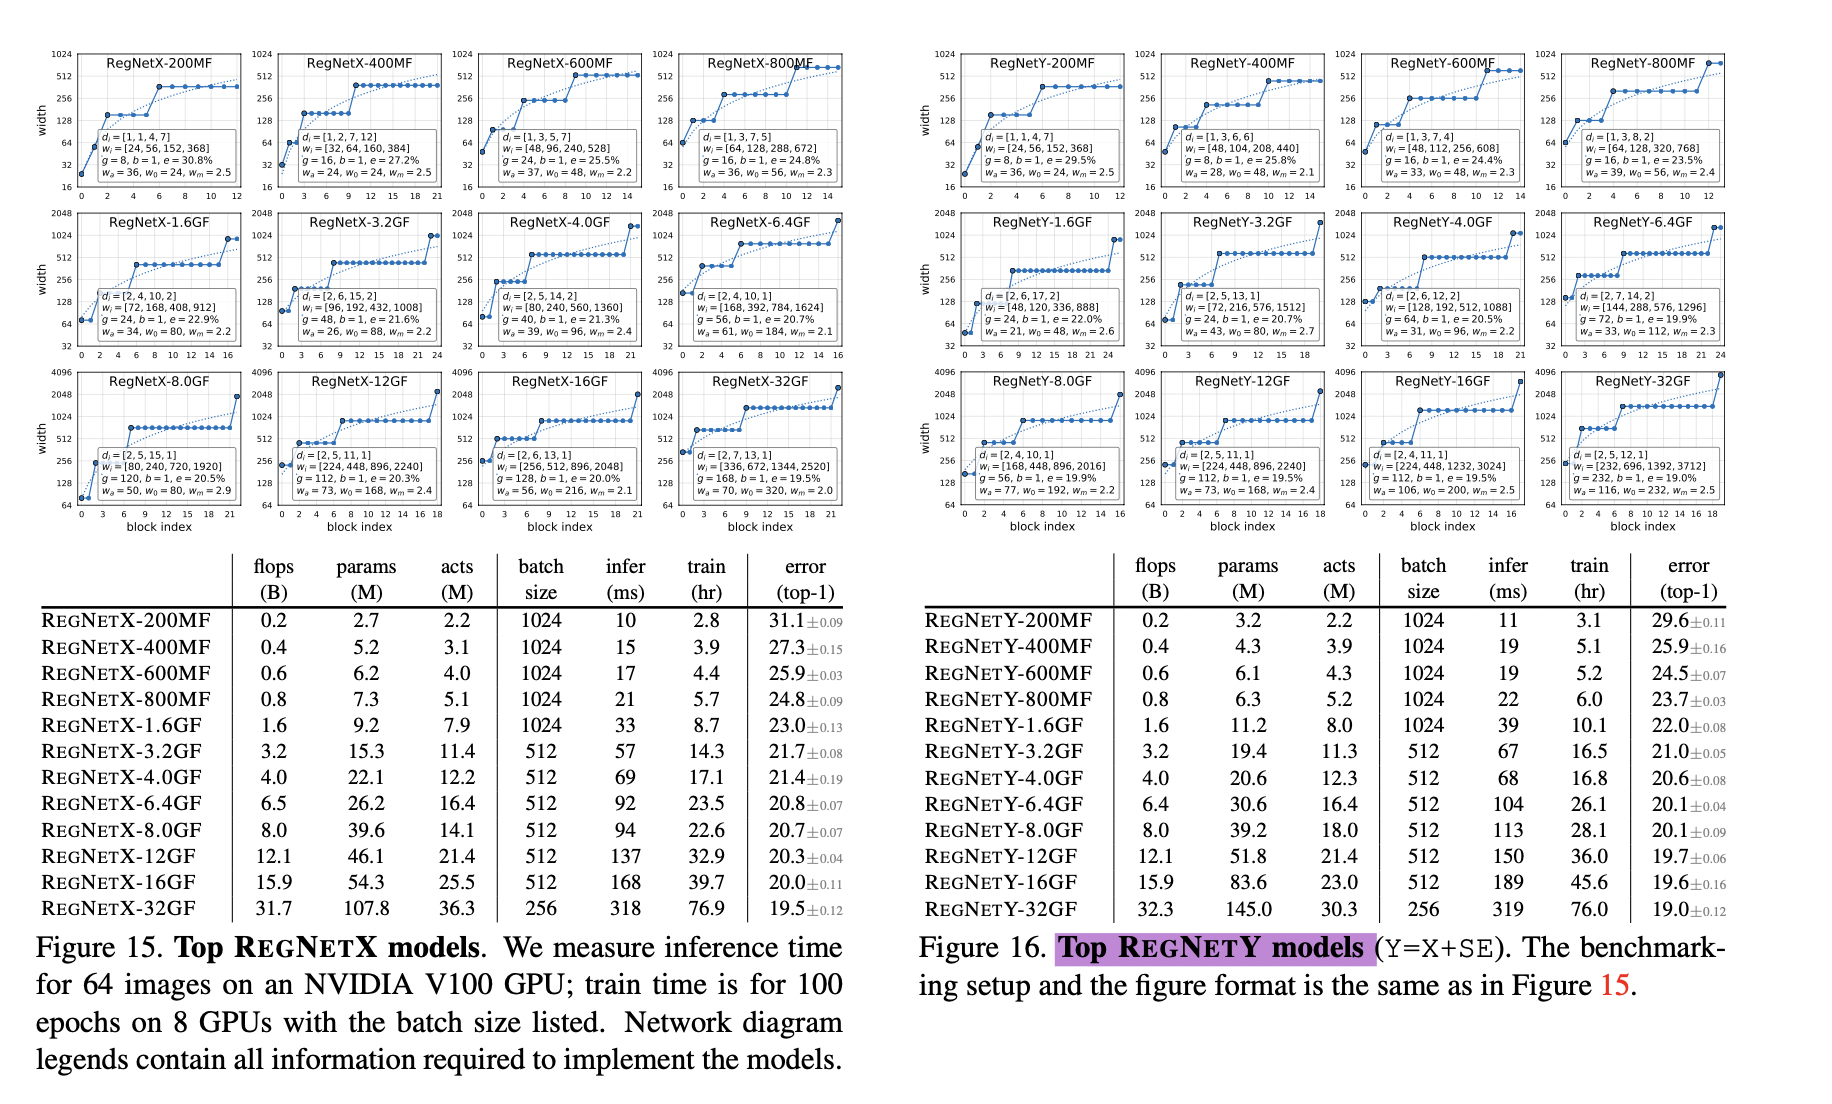

For more about those models, I recommend you read the [paper](https://arxiv.org/abs/2003.13678).

<a name='3'></a>

## 3. RegNet Implementation

We will implement `RegNetX-032`. RegNetX-032 has the following information:

```
"depths": [2, 6, 15, 2],
"widths": [96, 192, 432, 1008],
"group_width": 48,
"input resolution": 224,
"block_type": "X(no squeeze and excitation)
```


As always, let's build the whole network piece by piece, starting with the input stem. Note that every convolution layer is followed by batch normalization and ReLU layers.

### Set Up

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

### Stem

In [20]:
def stem(input):
  """
  stem of RegNetX032(same for other networks)
  input: input tensor
  """
  x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
  x = layers.BatchNormalization(epsilon=1e-5)(x)
  x = layers.ReLU()(x)

  return x

### RegNetX-3.2GF Conv Block

In [21]:
def conv_block(input, filters_out, group_width=48, strides=1):
  """
  RegNetX-032 block (RegNetX blocks don't have squeeze and excitation)

  input: input tensor
  filters_out: output filters
  group_width: group widths in grouped convolutions
  strides: strides in grouped convolution. 
  
  If strides=1, we add identity shortcut from input to output. 
  If strides=2, the shortcut has 1x1 conv with strides 2.
  """

  groups = filters_out // group_width

  x = layers.Conv2D(filters=filters_out, kernel_size=1, strides=1)(input)
  x = layers.BatchNormalization(epsilon=1e-5)(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filters_out, kernel_size=3, strides=strides, groups=groups, padding='same')(x)
  x = layers.BatchNormalization(epsilon=1e-5)(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filters_out, kernel_size=1, strides=1)(x)
  x = layers.BatchNormalization(epsilon=1e-5)(x)
  x = layers.ReLU()(x)

  if strides == 1:
    shortcut = input
    x = layers.Add()([x, shortcut])
  
  if strides == 2:
    shortcut = layers.Conv2D(filters=filters_out, kernel_size=1, strides=strides)(input)
    shortcut = layers.BatchNormalization(epsilon=1e-5)(shortcut)
    x = layers.Add()([x, shortcut])

  return x

### Building the Whole Network

Let's put everything together!

In [24]:
# Building RegNetX-032

input_shape = (224, 224, 3)
num_classes = 1000 # per imagenet

input = layers.Input(shape=input_shape)

# Stem
x = stem(input)

# RegNetX032 blocks
# Each stage has number of blocks n where the first block of each stage has stride of 2 in grouped convolution

# stage 1: 2 blocks, 96 channels(filters_out)
x = conv_block(x, 96, group_width=48, strides=2)
x = conv_block(x, 96, group_width=48, strides=1)

# stage 2: 6 blocks, 192 channels(filters_out)
x = conv_block(x, 192, group_width=48, strides=2)
for _ in range(1, 6):
  x = conv_block(x, 192, group_width=48, strides=1)

# stage 3: 15 blocks, 432 channels(filters_out)
x = conv_block(x, 432, group_width=48, strides=2)
for _ in range(1, 15):
  x = conv_block(x, 432, group_width=48, strides=1)

#stage 4: 2 blocks, 1008 channels(filters_out)
x = conv_block(x, 1008, group_width=48, strides=2)
x = conv_block(x, 1008, group_width=48, strides=1)

# classification head
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(units=num_classes, activation='softmax')(x)

#build the model
regnetx_032 = keras.Model(inputs=input, outputs=output)

Let's display the summary and plot the model we just built!

In [26]:
regnetx_032.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_245 (Conv2D)            (None, 112, 112, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_245 (Batch  (None, 112, 112, 32  128        ['conv2d_245[0][0]']             
 Normalization)                 )                                                           

Our `RegNetX-3.2GF`* has `15.3G` parameters. Looking at the specifications from the paper, we are quite close!

*GF means Giga FLOPS(floaping points)

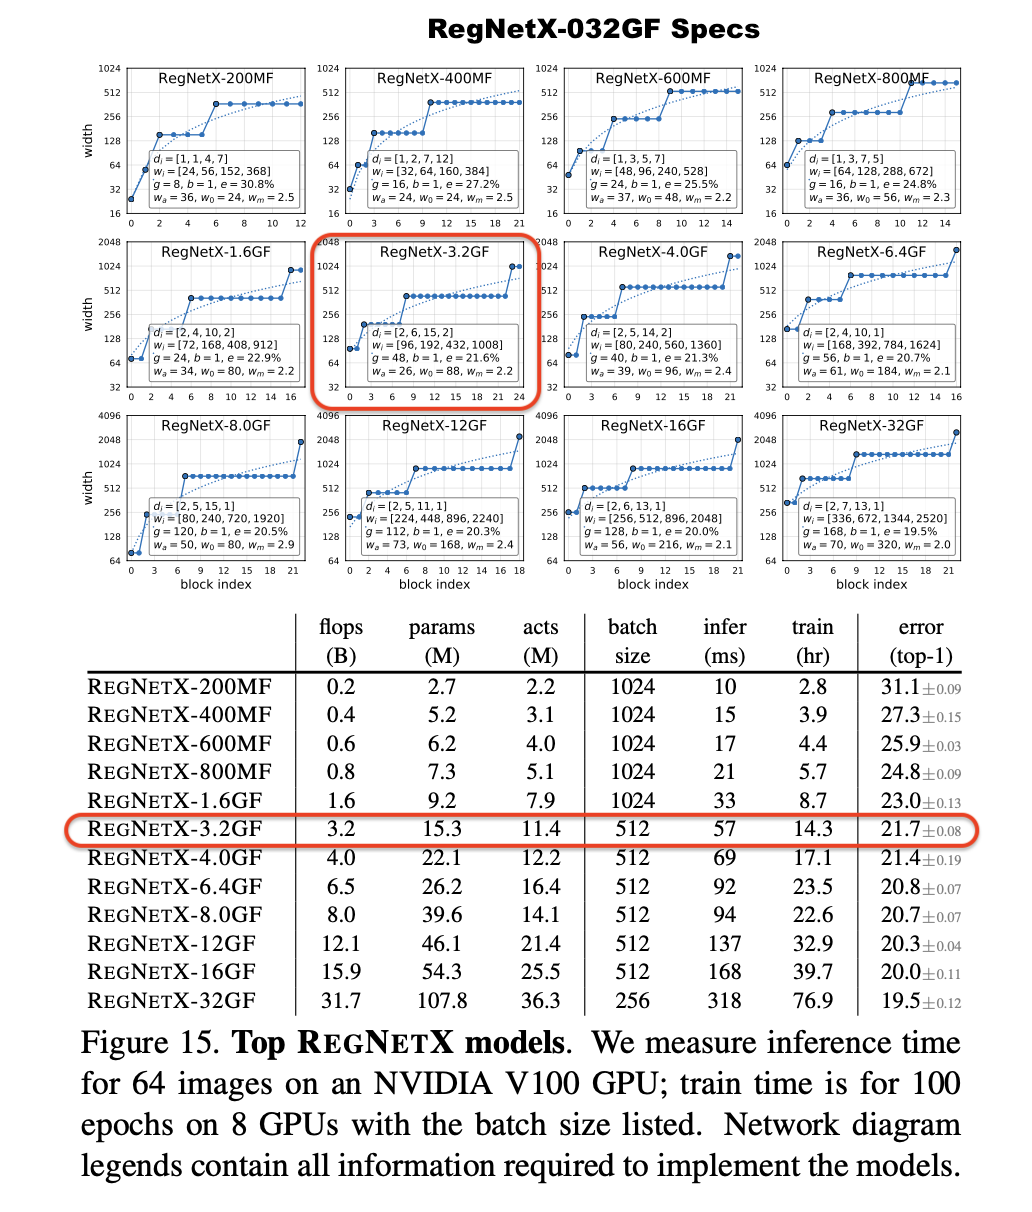

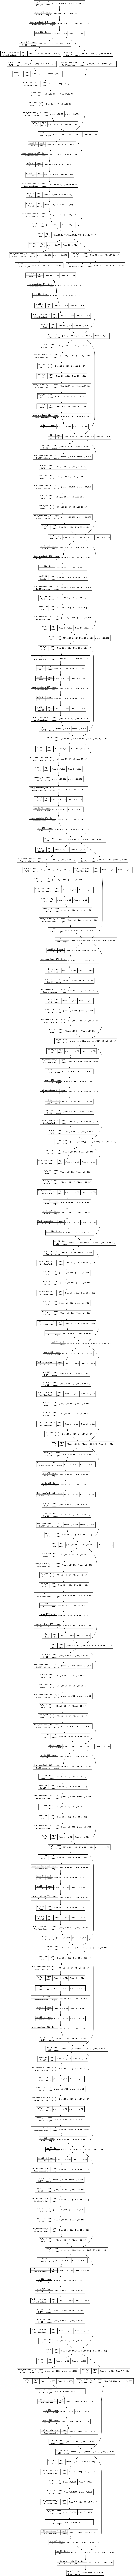

In [27]:
plot_model(regnetx_032, show_shapes=True)

<a name='4'></a>
## 4. Final Notes

RegNet presents a new paradigm of designing convolutional neural network architectures which is designing network design spaces that contain many efficient networks for various applications rather than designing a single architecture that works in single setting. 

Below image shows the comparison of RegNet models vs [ResNeXt](https://arxiv.org/abs/1611.05431v2) and [EfficientNet](https://arxiv.org/abs/1905.11946v5). A clear trend is that RegNet models perform better with fewer FLOPs and parameters compared to ResNeXt and EfficientNet.

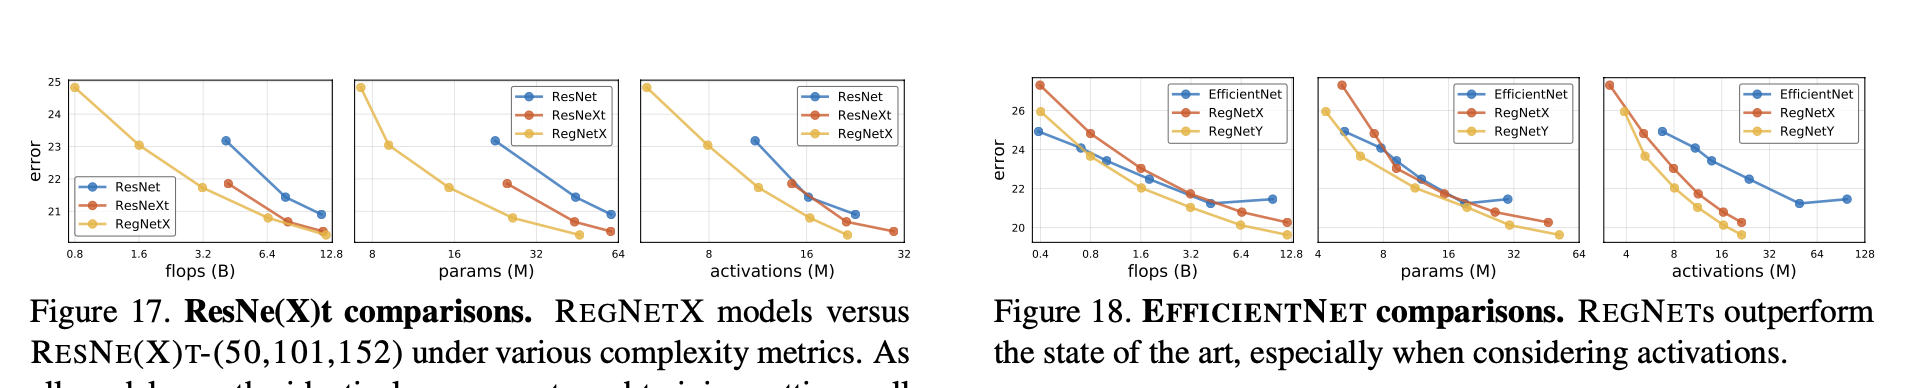

End note: I learned that Tesla runs RegNet in their autopilots models in [Tesla AI Day](https://www.youtube.com/watch?v=j0z4FweCy4M&t=2924s).

<a name='5'></a>

## 5. References Implementations

* [Keras Applications - RegNet](https://github.com/keras-team/keras/blob/master/keras/applications/regnet.py)

* [Official implementation(PyTorch)](https://github.com/facebookresearch/pycls/blob/main/pycls/models/regnet.py)

### [BACK TO TOP](#0)